# Per Gene Trajectory Visualization

Visualization of Gene Score, Expression and ChromVAR along trajectories for single genes. Developed on top of the `20201025_trajectory_viz/TrajViz.ipynb` notebook.

Inputs:
1. ATAC metadata
2. ATAC pseudotime
3. ATAC ChromVAR
4. ArchR Gene Score
5. RNA Seurat object
6. RNA clusters (transfered from ATAC)
7. CCA or similar coembedding coordinates for ATAC+RNA
8. Cluster and Day configs

In [1]:
library(Seurat)
library(ArchR)
library(RANN)
library(patchwork)
library(mgcv) # for smoothing

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    unio

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14")

In [3]:
addArchRThreads(threads = 32) 

Setting default number of Parallel threads to 32.



In [4]:
addArchRGenome("hg38")

Setting default genome to Hg38.



## Load Inputs

### ATAC MetaData

In [6]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../../analysis/20200206_pmat_snapATAC/sessions/20201022_n53906/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 53906     5

barcode          sample umap1    umap2     cluster
D0_AACGCGAGAAGGACCA AACGCGAGAAGGACCA D0     8.373301 -4.292619 5      
D0_AACGCGCTGTCTGTGA AACGCGCTGTCTGTGA D0     2.033609 -7.860645 5      
D0_ACCTATGGACTCGATA ACCTATGGACTCGATA D0     3.093788 -7.469210 5      
D0_ACGCAGAGATAACCCA ACGCAGAGATAACCCA D0     6.001364 -7.523576 5      
D0_ACTCGCTACTTGTGAC ACTCGCTACTTGTGAC D0     3.343237 -8.114589 5

### Cluster Config

In [7]:
cluster_config = read.table("../configs/cluster.tsv", comment.char = '', sep='\t', header=T)
cluster_config

cluster colour  description            new_cluster
1   1      #A6D854 Pre-iPSC               14         
2   2      #F0A118 Intermediate           12         
3   3      #E85F6D Fibroblast-like         3         
4   4      #006658 Neural-like             8         
5   5      #B03743 Fibroblast              1         
6   6      #CF175A Fibroblast-like         4         
7   7      #78A824 Pre-iPSC               13         
8   8      #F4D5CD Intermediate           11         
9   9      #D4B81C Intermediate            9         
10 10      #F01D35 Fibroblast-like         5         
11 11      #7C2730 Fibroblast-like         2         
12 12      #F7A6C2 Keratinocyte-like       6         
13 13      #406614 Partially-reprogrammed 10         
14 14      #F0520A Early intermediate      7

In [8]:
metaData$cluster_new_id = cluster_config[metaData$cluster, "new_cluster"]

### Day Config

In [9]:
day_config = read.table("../configs/day.tsv", 
                        comment.char = '', 
                        sep='\t', 
                        header=T,
                       stringsAsFactor=F)
rownames(day_config) = day_config$day
day_config

day colour 
D0  D0  #A61C24
D2  D2  #FF70A6
D4  D4  #D6E82F
D6  D6  #B14AED
D8  D8  #2D3142
D10 D10 #FC7753
D12 D12 #0AABB7
D14 D14 #336699

### ArchR Gene Score

In [10]:
ArrowFiles = c('D0.arrow',
               'D2.arrow',
               'D4.arrow',
               'D6.arrow',
               'D8.arrow',
               'D10.arrow',
               'D12.arrow',
               'D14.arrow')
#              'H1.arrow')

In [11]:
archr_proj <- ArchRProject(
  ArrowFiles = paste("/srv/scratch/surag/scATAC-reprog/arrow/", ArrowFiles, sep=''), 
  outputDirectory = "./tmp/",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

In [12]:
all(paste(metaData$sample, metaData$barcode, sep='#') %in% archr_proj$cellNames)

[1] TRUE

In [13]:
# subset to cells
archr_proj = archr_proj[paste(metaData$sample, metaData$barcode, sep='#'), ]

In [14]:
getAvailableMatrices(archr_proj)

[1] "GeneIntegrationMatrix" "GeneScoreMatrix"       "PeakMatrix"           
[4] "TileMatrix"

In [15]:
archr_gene_score = getMatrixFromProject(archr_proj, "GeneScoreMatrix")
dim(archr_gene_score)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-c83c1d77ac97-Date-2020-11-23_Time-04-41-58.log
If there is an issue, please report to github with logFile!

2020-11-23 04:43:44 : Organizing colData, 1.769 mins elapsed.

2020-11-23 04:43:44 : Organizing rowData, 1.771 mins elapsed.

2020-11-23 04:43:44 : Organizing Assays (1 of 1), 1.771 mins elapsed.

2020-11-23 04:44:44 : Constructing SummarizedExperiment, 2.759 mins elapsed.

2020-11-23 04:44:45 : Finished Matrix Creation, 2.784 mins elapsed.



[1] 24919 53906

In [16]:
archr_gene_score_mat = archr_gene_score@assays@data$GeneScoreMatrix
rownames(archr_gene_score_mat) = rowData(archr_gene_score)$name
colnames(archr_gene_score_mat) = sub("#", "_", rownames(colData(archr_gene_score)))
# reorder
archr_gene_score_mat = archr_gene_score_mat[, rownames(metaData)]

In [17]:
sum(is.na(archr_gene_score_mat))

[1] 0

In [18]:
# reclaim some memory
rm(archr_gene_score)
gc()

used      (Mb)   gc trigger (Mb)    max used   (Mb)   
Ncells   7897955  421.8   11519054   615.2   10221420   545.9
Vcells 649484103 4955.2 2130986343 16258.2 2201666083 16797.4

### Seurat Object

In [19]:
rna = readRDS("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/seurat.rds")
rna$tech = "rna"

### ATAC-RNA Label Transfer

In [20]:
atac.rna.label = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.cluster.transfer.tsv",
                           header=T)
rownames(atac.rna.label) = atac.rna.label$barcode
atac.rna.label$barcode = NULL

all(rownames(atac.rna.label)==colnames(rna))

# transfer to new cluster
atac.rna.label$atac_new_cluster = cluster_config[atac.rna.label$atac_cluster, "new_cluster"]

head(atac.rna.label)

[1] TRUE

sample atac_cluster atac_new_cluster
AAACCCAAGAGTGACC-1 D0     5            1               
AAACCCAAGTGCCAGA-1 D0     5            1               
AAACCCACACCATTCC-1 D0     5            1               
AAACCCACACGCGTCA-1 D0     5            1               
AAACCCAGTCCATAGT-1 D0     5            1               
AAACCCAGTTATTCTC-1 D0     5            1

### ATAC Pseudotime

In [21]:
pseudotime = read.table("../../analysis/20200217_trajectory/sessions/20201022_n53906/pseudotime.tsv")
rownames(pseudotime) = pseudotime$sample_barcode
pseudotime$sample_barcode = NULL
all(rownames(pseudotime) == rownames(metaData))
head(pseudotime)

[1] TRUE

dpt_pseudotime
D0_AACGCGAGAAGGACCA 0.00000000    
D0_AACGCGCTGTCTGTGA 0.20646924    
D0_ACCTATGGACTCGATA 0.17054172    
D0_ACGCAGAGATAACCCA 0.09116346    
D0_ACTCGCTACTTGTGAC 0.16613631    
D0_AGACTACTGGCAGTTT 0.05593833

### ChromVAR Scores

In [22]:
# Load ChromVAR 
chromvar = read.table(gzfile("../../analysis/20200607_ChromVAR/out/20201020_n62402/20201119_bpnet.no_iPSC.FDR_0.1_hits.tsv"),
                            check.names=FALSE, # keeps + in FOS+JUN instead of converting to FOS.JUN
                      sep='\t')
all(rownames(metaData) %in% rownames(chromvar))
chromvar = chromvar[rownames(metaData),] 
head(chromvar)

[1] TRUE

AP2A_HUMAN.H11MO.0.A AP2A_MOUSE.H11MO.0.A
D0_AACGCGAGAAGGACCA -0.12294065          -0.09352625         
D0_AACGCGCTGTCTGTGA -0.12821733          -0.09127279         
D0_ACCTATGGACTCGATA -0.09000103          -0.07525123         
D0_ACGCAGAGATAACCCA -0.13996900          -0.11293790         
D0_ACTCGCTACTTGTGAC -0.29016466          -0.26960139         
D0_AGACTACTGGCAGTTT -0.05789882          -0.03753335         
                    AP2C_HUMAN.H11MO.0.A Ascl2.mouse_bHLH_1
D0_AACGCGAGAAGGACCA -0.10794921           0.08798450       
D0_AACGCGCTGTCTGTGA -0.11971037          -0.05039826       
D0_ACCTATGGACTCGATA -0.05044384           0.02199156       
D0_ACGCAGAGATAACCCA -0.12036074           0.03213452       
D0_ACTCGCTACTTGTGAC -0.26274589          -0.08115598       
D0_AGACTACTGGCAGTTT -0.03960972           0.07398756       
                    ATF1_MOUSE.H11MO.0.B BATF+JUN_MA0462.1 CEBPA_MA0102.3
D0_AACGCGAGAAGGACCA  0.018353336         0.03361392         0.34264057   
D0_AACGCGCTGTCTGTGA -0.165470322         0.17952061        -0.06281021   
D0_ACCTATGGACTCGATA  0.064826831         0.16002619         0.17504433   
D0_ACGCAGAGATAACCCA  0.007410609         0.10376001         0.06106466   
D0_ACTCGCTACTTGTGAC  0.169576565         0.17302266         0.05314971   
D0_AGACTACTGGCAGTTT  0.126405154         0.12559693         0.39322449   
                    CEBPB_MOUSE.H11MO.0.A CREB1_MA0018.3 CREB3_bZIP_1 ⋯
D0_AACGCGAGAAGGACCA  0.22410861            0.12877157     0.10686871  ⋯
D0_AACGCGCTGTCTGTGA -0.08282114            0.12301088     0.12257224  ⋯
D0_ACCTATGGACTCGATA  0.16178425           -0.01575793    -0.04535254  ⋯
D0_ACGCAGAGATAACCCA  0.04992117            0.10107298     0.08227665  ⋯
D0_ACTCGCTACTTGTGAC  0.21316328            0.08961263     0.11566191  ⋯
D0_AGACTACTGGCAGTTT  0.30191576            0.07435968     0.10389412  ⋯
                    VEZF1_HUMAN.H11MO.0.C YY1_MA0095.2 ZBTB18_MA0698.1
D0_AACGCGAGAAGGACCA -0.05705881           -0.035062317  0.0654240384  
D0_AACGCGCTGTCTGTGA -0.05607968           -0.068237933 -0.0634596941  
D0_ACCTATGGACTCGATA -0.04363534           -0.032693962  0.0083265061  
D0_ACGCAGAGATAACCCA -0.06270160           -0.157120673  0.0279788745  
D0_ACTCGCTACTTGTGAC -0.11856937            0.002780547 -0.2417367283  
D0_AGACTACTGGCAGTTT -0.02603083           -0.093000115  0.0005260283  
                    ZBTB33_MA0527.1 ZFX_MOUSE.H11MO.0.B ZN143_HUMAN.H11MO.0.A
D0_AACGCGAGAAGGACCA -0.003564588    -0.03832660         -0.03587245          
D0_AACGCGCTGTCTGTGA  0.032931037    -0.04811726         -0.02580824          
D0_ACCTATGGACTCGATA -0.079405863    -0.01814928         -0.03548759          
D0_ACGCAGAGATAACCCA -0.047696751    -0.04599367         -0.09518446          
D0_ACTCGCTACTTGTGAC  0.138115475    -0.13441524         -0.10250958          
D0_AGACTACTGGCAGTTT -0.059059651    -0.01943282         -0.04448186          
                    ZN143_MOUSE.H11MO.0.A ZNF238_C2H2_1 ZNF238_C2H2_2
D0_AACGCGAGAAGGACCA -0.03941892            0.04882215    0.0654240384
D0_AACGCGCTGTCTGTGA -0.02821128           -0.04213231   -0.0634596941
D0_ACCTATGGACTCGATA -0.01061891            0.03299011    0.0083265061
D0_ACGCAGAGATAACCCA -0.09121124            0.05588418    0.0279788745
D0_ACTCGCTACTTGTGAC -0.17400573           -0.25518424   -0.2417367283
D0_AGACTACTGGCAGTTT -0.02886792            0.02527477    0.0005260283
                    ZNF76_HUMAN.H11MO.0.C
D0_AACGCGAGAAGGACCA -0.06306453          
D0_AACGCGCTGTCTGTGA -0.06673984          
D0_ACCTATGGACTCGATA -0.03533180          
D0_ACGCAGAGATAACCCA -0.05976590          
D0_ACTCGCTACTTGTGAC -0.14147841          
D0_AGACTACTGGCAGTTT -0.04497569

### Coembedding 

In [23]:
head(colnames(rna))

[1] "AAACCCAAGAGTGACC-1" "AAACCCAAGTGCCAGA-1" "AAACCCACACCATTCC-1"
[4] "AAACCCACACGCGTCA-1" "AAACCCAGTCCATAGT-1" "AAACCCAGTTATTCTC-1"

In [24]:
coembedding = read.table("../../analysis/20200828_RNA_Seurat/sessions/20200913_n59369/atac.20201022_n53906.harmony.cca.tsv")

all(rownames(coembedding) == c(colnames(rna), rownames(metaData)))

dim(coembedding)
head(coembedding)

[1] TRUE

[1] 113275     16

tech harmony_1  harmony_2    harmony_3  harmony_4  
AAACCCAAGAGTGACC-1 rna  0.29773394  0.060780809 0.37018690  0.19983989
AAACCCAAGTGCCAGA-1 rna  0.28259904  0.029176483 0.24774358  0.21202861
AAACCCACACCATTCC-1 rna  0.19551768 -0.003477105 0.25965475  0.04794585
AAACCCACACGCGTCA-1 rna  0.09708915  0.025200052 0.19250754  0.15577251
AAACCCAGTCCATAGT-1 rna  0.14888114  0.085361749 0.05839939  0.03823448
AAACCCAGTTATTCTC-1 rna  0.19591517  0.007899533 0.23764734 -0.10709950
                   harmony_5   harmony_6   harmony_7   harmony_8   harmony_9  
AAACCCAAGAGTGACC-1  0.03008437  0.06041451  0.09856335  0.19131867  0.06073175
AAACCCAAGTGCCAGA-1 -0.01328118 -0.04644758  0.08735725  0.09445840  0.07126179
AAACCCACACCATTCC-1  0.00807158 -0.03565429  0.06622923  0.04148270 -0.15486719
AAACCCACACGCGTCA-1  0.02606344  0.07642032 -0.04095093 -0.08716850 -0.18003416
AAACCCAGTCCATAGT-1  0.21796512 -0.02450189 -0.03054403 -0.06001743 -0.03939952
AAACCCAGTTATTCTC-1 -0.16534263 -0.06857853  0.13958501 -0.02611316  0.04922825
                   harmony_10   harmony_11   harmony_12  harmony_13   
AAACCCAAGAGTGACC-1  0.075185428  0.002075287 -0.00138196  0.0696568031
AAACCCAAGTGCCAGA-1 -0.176678789  0.060986344 -0.06466362 -0.1243335302
AAACCCACACCATTCC-1 -0.072531205  0.099665928  0.24693218 -0.0141086953
AAACCCACACGCGTCA-1  0.090375417 -0.080367276  0.15396999  0.0728915400
AAACCCAGTCCATAGT-1 -0.002925019  0.009129636  0.34440203  0.1157595817
AAACCCAGTTATTCTC-1 -0.039199167  0.089413703  0.05449364 -0.0004101254
                   harmony_14  harmony_15 
AAACCCAAGAGTGACC-1  0.01121586  0.04240550
AAACCCAAGTGCCAGA-1 -0.14314382 -0.05377942
AAACCCACACCATTCC-1 -0.04370388 -0.24862321
AAACCCACACGCGTCA-1  0.05312232 -0.08005201
AAACCCAGTCCATAGT-1 -0.01071808 -0.22913379
AAACCCAGTTATTCTC-1 -0.47859847 -0.03039417

## Preprocessing

### Nearest Neighbor ATAC->RNA

In [25]:
# euclidean RNA NN for each ATAC cell
# atac2rna_nn = nn2(coembedding[coembedding$tech=="rna", 2:ncol(coembedding)],
#                     query=coembedding[coembedding$tech=="atac", 2:ncol(coembedding)],
#                     10)

In [26]:
# head(atac2rna_nn$nn.idx)

In [27]:
# or restrict to same cluster
K = 10
atac2rna_same_cluster_nn = matrix(0, nrow(metaData), K)
for (c in sort(unique(metaData$cluster_new_id))) {
    c2c_nn = nn2(coembedding[coembedding$tech=="rna", 2:ncol(coembedding)][atac.rna.label$atac_new_cluster == c, ],
                    query=coembedding[coembedding$tech=="atac", 2:ncol(coembedding)][metaData$cluster_new_id == c,],
                    K)$nn.idx
    
    orig_rna_idx = which(atac.rna.label$atac_new_cluster == c)
    
    # get original idx
    c2c_nn = matrix(orig_rna_idx[c2c_nn], nrow=nrow(c2c_nn))
        
    atac2rna_same_cluster_nn[metaData$cluster_new_id == c, ] = c2c_nn
}

## Plot

In [28]:
plot_dimred <- function(x, y, col, dimred="UMAP", subset=NULL, sz=0.5) {
    plot_df <- data.frame(x=x, y=y,
                 cluster=col)
    plot_df = plot_df[sample(dim(plot_df)[1]), ]
    
    if (!is.null(subset)) {
        plot_df = plot_df[plot_df$cluster==subset, ]
    }
    
    ggplot(plot_df) +
    geom_point(aes(x=x, y=y, color=cluster), stroke=0, size=sz) +
    theme_classic() +
    xlab(sprintf("%s 1", dimred)) + ylab(sprintf("%s 2", dimred)) +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) 
}

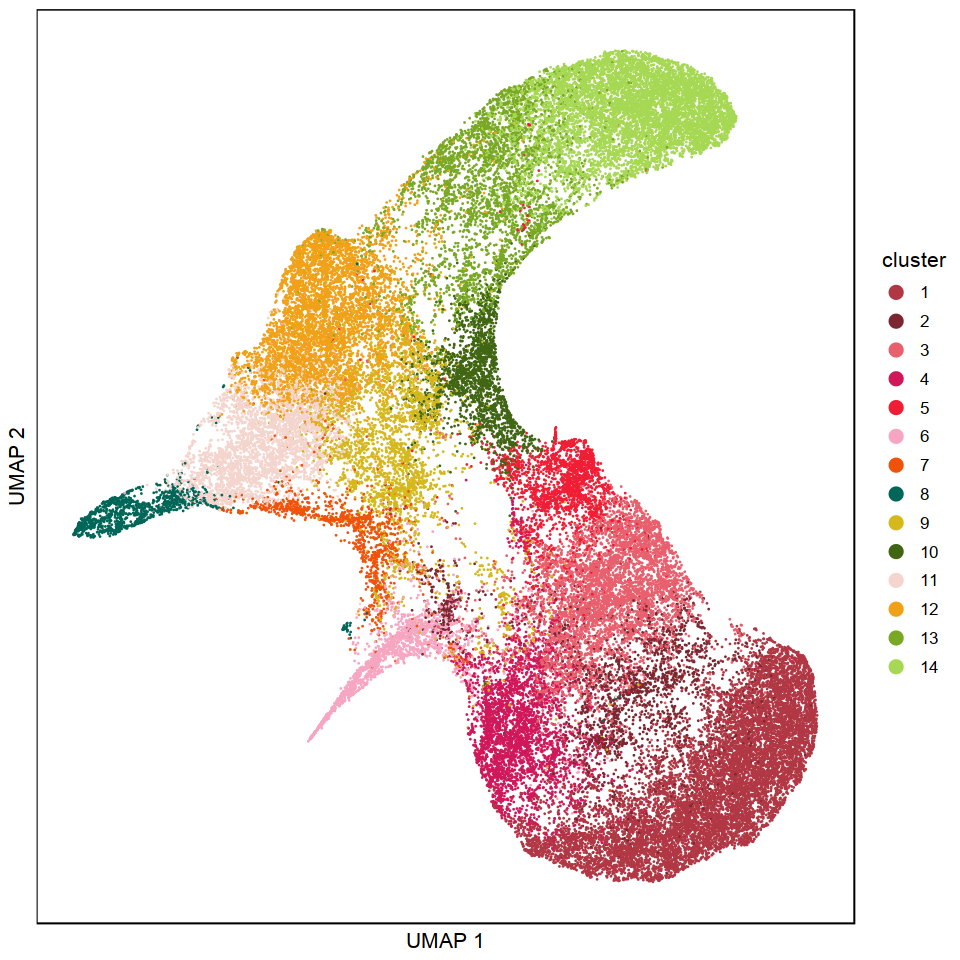

In [29]:
options(repr.plot.width = 8, repr.plot.height = 8)

plot_dimred(metaData$umap1,
           metaData$umap2,
           factor(metaData$cluster_new_id)) + 
scale_color_manual(values=as.character(cluster_config$colour)[order(cluster_config$new_cluster)]) +
guides(colour = guide_legend(override.aes = list(shape=16, alpha=1, size=4)))

### Genes Along Pseudotime

In [30]:
ATAC_SEL = which(metaData$cluster_new_id %in% c(1,7,11,12,13,14))

In [31]:
# RNA_SEL = atac2rna_nn$nn.idx[ATAC_SEL, 1]
RNA_SEL = atac2rna_same_cluster_nn[ATAC_SEL, 1]

In [32]:
atac.path.df <- data.frame(x = smooth.spline(metaData$umap1[ATAC_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], df=200, spar=.9)$y, 
                        y = smooth.spline(metaData$umap2[ATAC_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], df=200, spar=.9)$y)

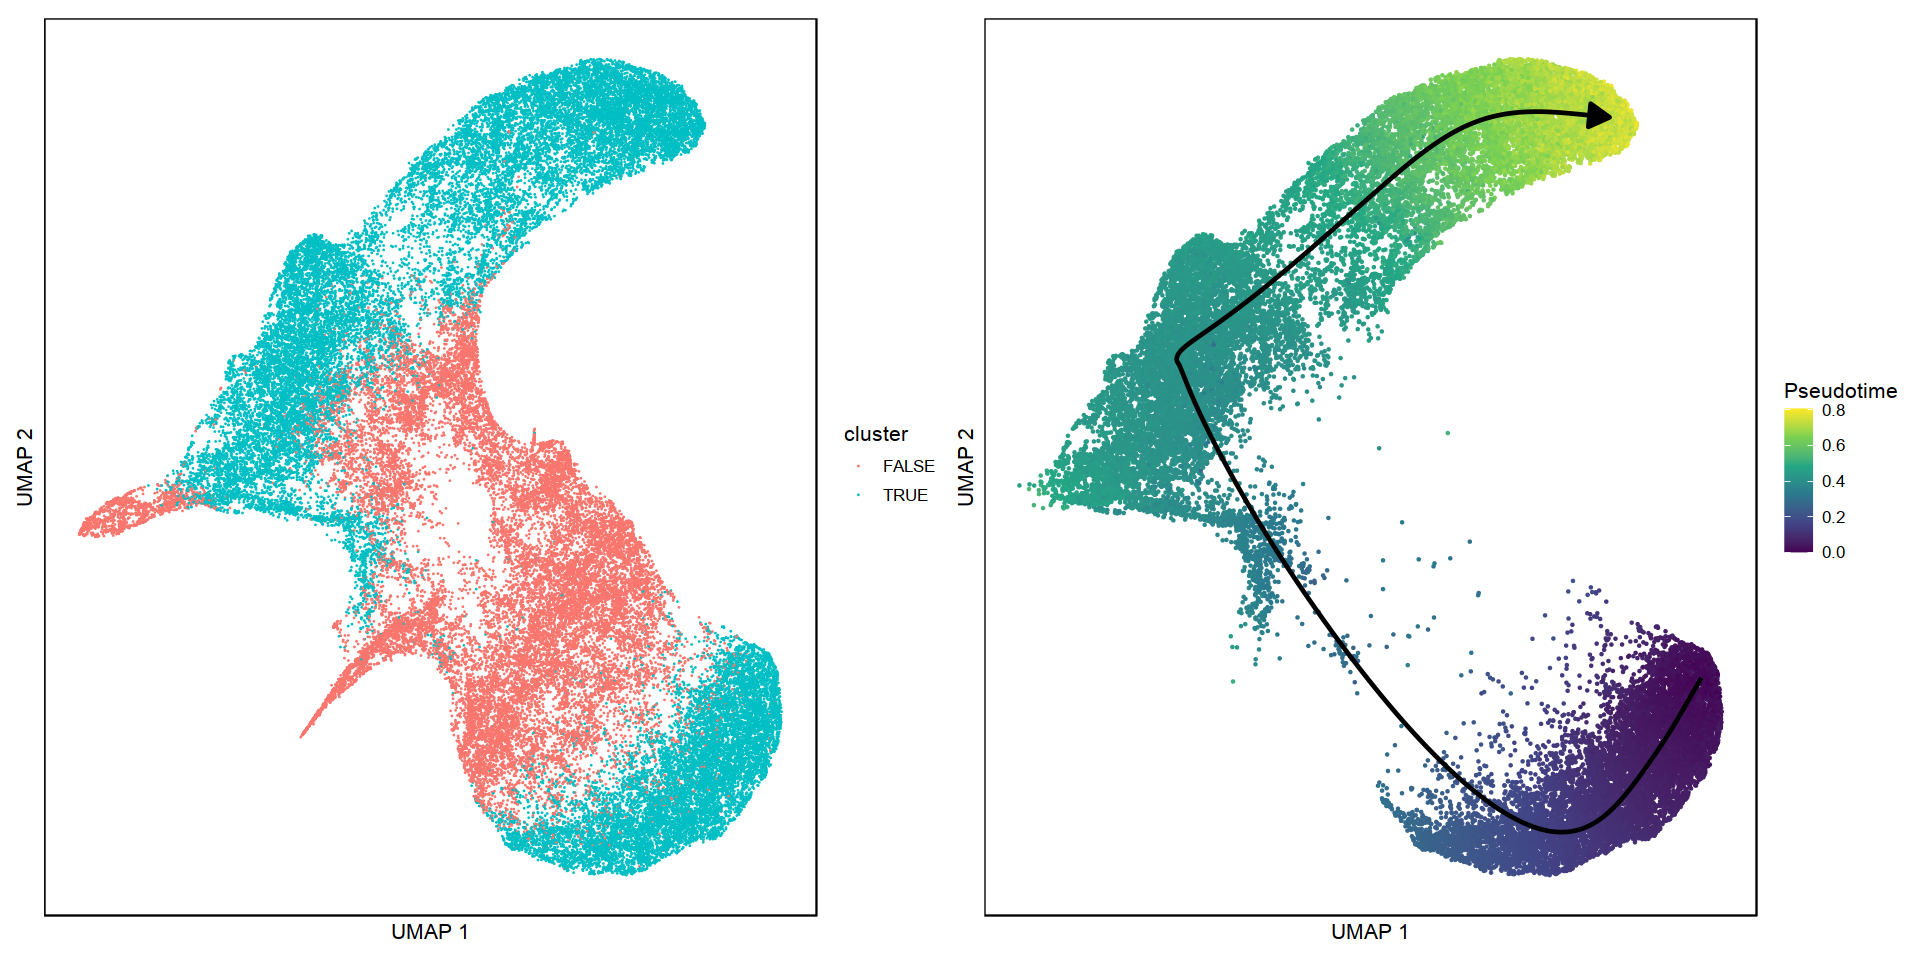

In [33]:
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(metaData$umap1,
           metaData$umap2,
           seq(nrow(metaData)) %in% ATAC_SEL)) |
(plot_dimred(metaData$umap1[ATAC_SEL],
           metaData$umap2[ATAC_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1) + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=atac.path.df, 
          aes(x, y), 
          size=1,
          color="black", 
          arrow=arrow(type="closed",
                     length=unit(.03, "npc"))))

In [34]:
rna.path.df <- data.frame(x = smooth.spline(rna@reductions$umap@cell.embeddings[,1][RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y, 
                          y = smooth.spline(rna@reductions$umap@cell.embeddings[,2][RNA_SEL][order(pseudotime[ATAC_SEL,"dpt_pseudotime"])], 
                                            df=200, spar=.8)$y)

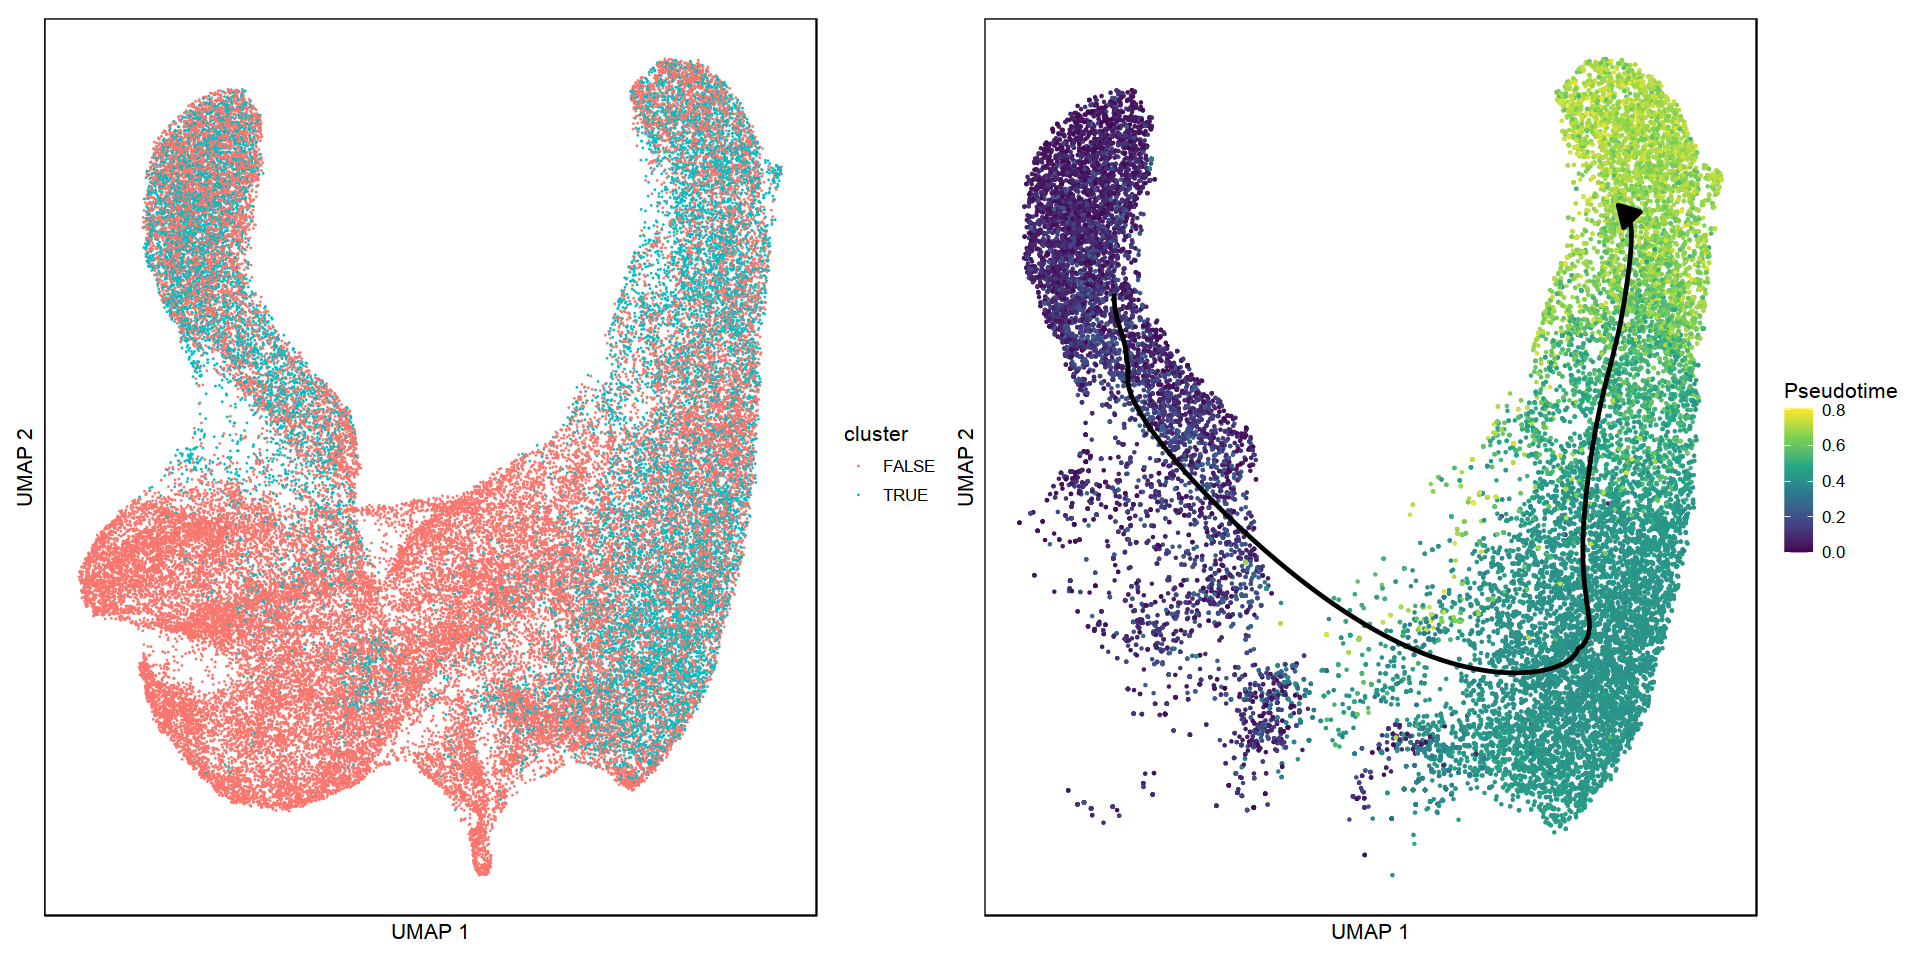

In [35]:
options(repr.plot.width = 16, repr.plot.height = 8)

(plot_dimred(rna@reductions$umap@cell.embeddings[,1],
           rna@reductions$umap@cell.embeddings[,2],
           seq(ncol(rna)) %in% RNA_SEL)) |
(plot_dimred(rna@reductions$umap@cell.embeddings[,1][RNA_SEL],
           rna@reductions$umap@cell.embeddings[,2][RNA_SEL],
           pseudotime[ATAC_SEL,"dpt_pseudotime"],
           sz=1)  + 
scale_color_viridis_c(name="Pseudotime") +
geom_path(data=rna.path.df, 
      aes(x, y), 
      size=1,
      color="black", 
      arrow=arrow(type="closed",
                 length=unit(.03, "npc"))))

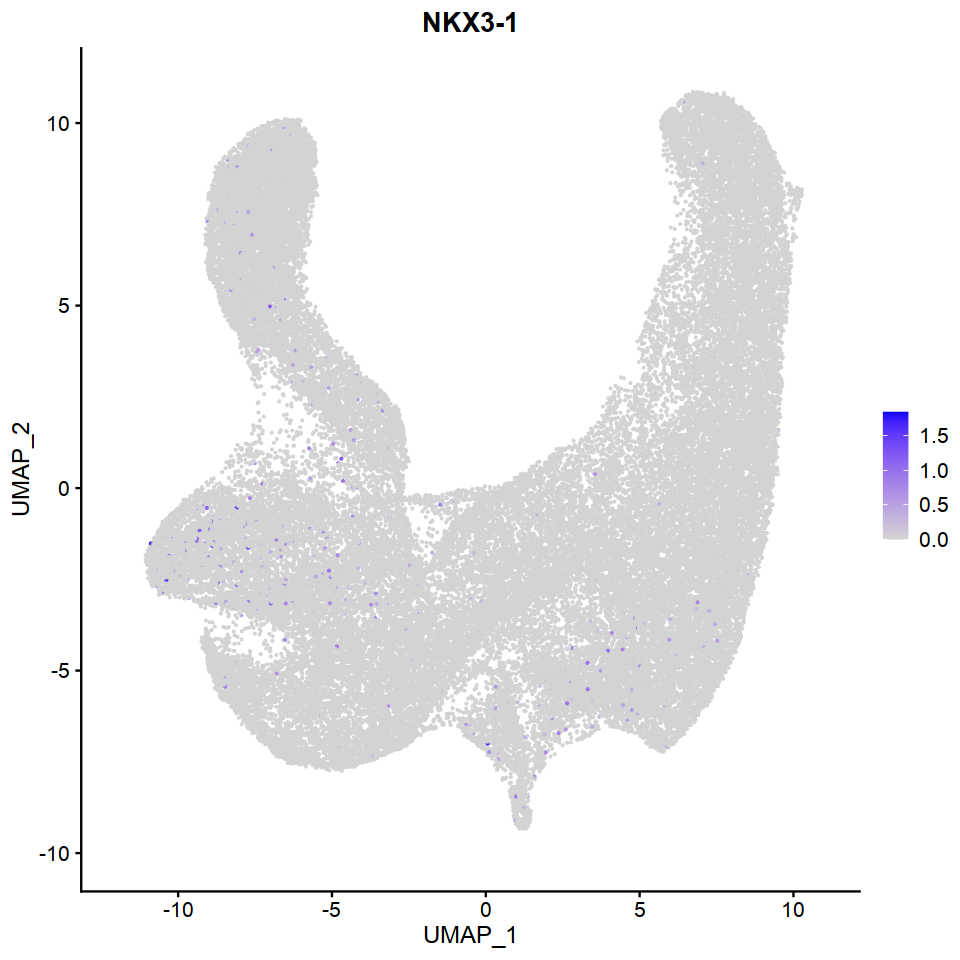

In [252]:
options(repr.plot.width = 8, repr.plot.height = 8)

FeaturePlot(rna, features = c("NKX3-1"), reduction = "umap", pt.size = 0.1, combine = FALSE)[[1]]

## Plot

In [43]:
all(rownames(metaData)[ATAC_SEL] %in% rownames(chromvar))

[1] TRUE

In [44]:
# further subset if required
subset_atac_sel = ATAC_SEL[rownames(metaData)[ATAC_SEL] %in% rownames(chromvar)]

# subset_rna_sel = atac2rna_nn$nn.idx[subset_atac_sel, 1] # without same cluster NN constraint
subset_rna_sel = atac2rna_same_cluster_nn[subset_atac_sel, 1]
length(subset_atac_sel)

[1] 32447

In [62]:
# median day of every n cells along pseudotime
get_median_day_every_n <- function(days, n=100) {
    rounded_length = floor(length(days)/n)*n

    days_numeric = as.numeric(lapply(strsplit(as.character(days), "D"), "[[", 2))[1:rounded_length]

    averaged_days = colMedians(matrix(days_numeric, n))

    averaged_days = floor(averaged_days/2)*2 # when medians are odd

    averaged_days = paste("D", averaged_days, sep="")    
    
    averaged_days
}

In [71]:
ROUND_EVERY=100

In [72]:
atac_averaged_days = get_median_day_every_n(metaData[subset_atac_sel[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])], "sample"], n=ROUND_EVERY)
rna_averaged_days = get_median_day_every_n(rna$sample[subset_rna_sel[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])]], n=ROUND_EVERY)

In [64]:
table(atac_averaged_days)
table(rna_averaged_days)

atac_averaged_days
 D0 D10 D12 D14  D2  D4  D6  D8 
109   6   8  97  11   3  70  20 

rna_averaged_days
 D0 D10 D12 D14  D2  D4  D6  D8 
106  18  35  65   3   9  43  45 

In [65]:
cur_pseudotime = pseudotime[subset_atac_sel,"dpt_pseudotime"]

In [162]:
make_plot <- function(gene, motif, with_day_colours=T, legend=F) {
    cur_expr = rna@assays$RNA@data[gene, subset_rna_sel]
    cur_gene_score = archr_gene_score_mat[gene, subset_atac_sel]    
    cur_chromvar = chromvar[subset_atac_sel, motif]
    
    EXPR_vals = cur_expr[order(cur_pseudotime)]

    # smoothed min-max norm
    smoothed = predict(gam(y ~ s(x, bs="cs"), 
                           data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                             y=EXPR_vals)))

    EXPR_vals = EXPR_vals - min(smoothed)
    EXPR_vals = EXPR_vals/(max(smoothed)-min(smoothed))
    
    GS_vals = log2(1+cur_gene_score[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])])

    # smoothed min-max norm
    smoothed = predict(gam(y ~ s(x, bs="cs"), 
                           data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                             y=GS_vals)))

    GS_vals = GS_vals - min(smoothed)
    GS_vals = GS_vals/(max(smoothed)-min(smoothed))
    
    CV_vals = cur_chromvar[order(pseudotime[subset_atac_sel,"dpt_pseudotime"])]

    # smoothed min-max norm
    smoothed = predict(gam(y ~ s(x, bs="cs"), 
                           data = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                                             y=CV_vals)))

    CV_vals = CV_vals - min(smoothed)
    CV_vals = CV_vals/(max(smoothed)-min(smoothed))
    
    EXPR_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime), 
                    y=EXPR_vals,
                    z="Expression")
    GS_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                      y=GS_vals,
                      z="Gene Score")
    CV_df = data.frame(x=seq(length(EXPR_vals)), #sort(cur_pseudotime)
                      y=CV_vals,
                      z="ChromVAR Score")

    plot_df = rbind(EXPR_df, GS_df, CV_df)
    # plot_df = rbind(EXPR_df, GS_df)

    # shuffle
    plot_df = plot_df[sample(nrow(plot_df)), ]
    
    integrated_plot <- ggplot(plot_df) + 
        # geom_point(aes (x=x,y=y,colour=z,group=z), stroke=0, size=1, alpha=0.1) +
        geom_smooth(aes(x=x,y=y,colour=z, group=z), 
                    method = 'gam', 
                    formula = y ~ s(x, bs = "cs")) +
        xlab("Pseudotime Order") +
        ylab("Normalized Scores") +
        ggtitle(gene) +
        coord_cartesian(ylim=c(-0.1,1.1)) +
        theme_linedraw() +
        theme(plot.title = element_text(hjust = 0.5),
              axis.text.x = element_blank(),
             text = element_text(size=16))
    
    if (with_day_colours==T) {
        i=1
        for (j in seq(1,length(atac_averaged_days))) {
            if ((atac_averaged_days[i] != atac_averaged_days[j]) || (j==length(atac_averaged_days))) {
                integrated_plot = integrated_plot + annotate("segment", 
                                                             x=((i-1)*ROUND_EVERY+1), 
                                                             xend=((j-1)*ROUND_EVERY),
                                                     y= -0.07, yend= -0.07, size=2.5,
                                                     color=day_config[atac_averaged_days[i], "colour"])
                i=j
            }
            
        }
    
        i=1
        for (j in seq(1,length(rna_averaged_days))) {
            if ((rna_averaged_days[i] != rna_averaged_days[j]) || (j==length(rna_averaged_days))) {
                integrated_plot = integrated_plot + annotate("segment", 
                                                             x=((i-1)*ROUND_EVERY+1), 
                                                             xend=((j-1)*ROUND_EVERY),
                                                             y= -0.12, yend= -0.12, size=2.5,
                                                             color=day_config[rna_averaged_days[i], "colour"])
                i=j
            }
        }

        integrated_plot = integrated_plot + annotate("text", x=500, y=-0.07, hjust=0, label="ATAC", color="white")
        integrated_plot = integrated_plot + annotate("text", x=500, y=-0.12, hjust=0, label="RNA", color="white")
    }
    
    if (legend==F) {
        integrated_plot = integrated_plot + theme(legend.position = "none") 
    }
    
    integrated_plot
}

In [115]:
GENE = "ZFX"
# print(colnames(chromvar)[grep(g, colnames(chromvar), ignore.case = T)])
# TF = colnames(chromvar)[grep(g, colnames(chromvar), ignore.case = T)][1]
# TF

In [122]:
motif = "ctcf"
colnames(chromvar)[grep(motif, colnames(chromvar), ignore.case=T)]
MOTIF = colnames(chromvar)[grep(motif, colnames(chromvar), ignore.case=T)][3]

[1] "CTCF_HUMAN.H11MO.0.A"  "CTCF_MA0139.1"         "CTCF_MOUSE.H11MO.0.A" 
[4] "CTCFL_HUMAN.H11MO.0.A" "CTCFL_MOUSE.H11MO.0.A"

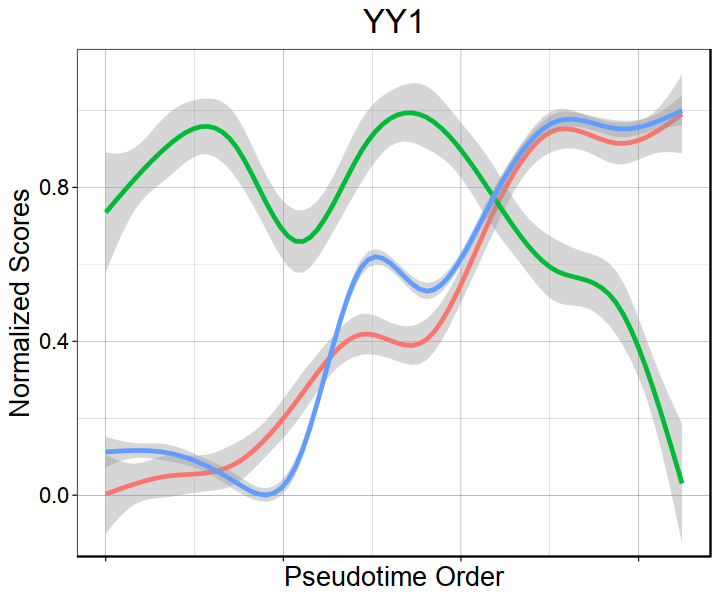

In [121]:
options(repr.plot.width = 6, repr.plot.height = 5)

make_plot("YY1", "YY1_MA0095.2", with_day_colours = F)

In [164]:
OCT4 = make_plot("POU5F1", "PO5F1_HUMAN.H11MO.0.A")
SOX2 = make_plot("SOX2", "SOX2_MOUSE.H11MO.0.A")
KLF4 = make_plot("KLF4", "KLF4_HUMAN.H11MO.0.A")
MYC = make_plot("MYC", "MYC_HUMAN.H11MO.0.A")

In [165]:
JUN = make_plot("JUN", "JUN_HUMAN.H11MO.0.A")
RUNX1 = make_plot("RUNX1", "RUNX1_HUMAN.H11MO.0.A")

In [166]:
TFAP2C = make_plot("TFAP2C", "AP2C_HUMAN.H11MO.0.A")
CTCF = make_plot("CTCF", "CTCF_HUMAN.H11MO.0.A")

In [167]:
legend = cowplot::get_legend(make_plot("CTCF", "CTCF_HUMAN.H11MO.0.A", with_day_colours = F, legend = T) +
                             theme(legend.position = "bottom", 
                                   legend.box = "horizontal",
                                  legend.title=element_blank()))

In [168]:
oskm = wrap_plots(OCT4, SOX2, 
           KLF4, MYC, nrow=2)
tc = wrap_plots(TFAP2C,
                CTCF, nrow=2)
jr = wrap_plots(JUN,
               RUNX1, nrow=2)

In [169]:
combined = wrap_plots(oskm, 
                      plot_spacer(), 
                      tc, 
                      plot_spacer(),
                      jr,
                      widths=c(10,.5,5,.5,5)
                     )
combined_with_legend = wrap_plots(combined,
                                 legend,
                                 heights=c(7.5,.5))

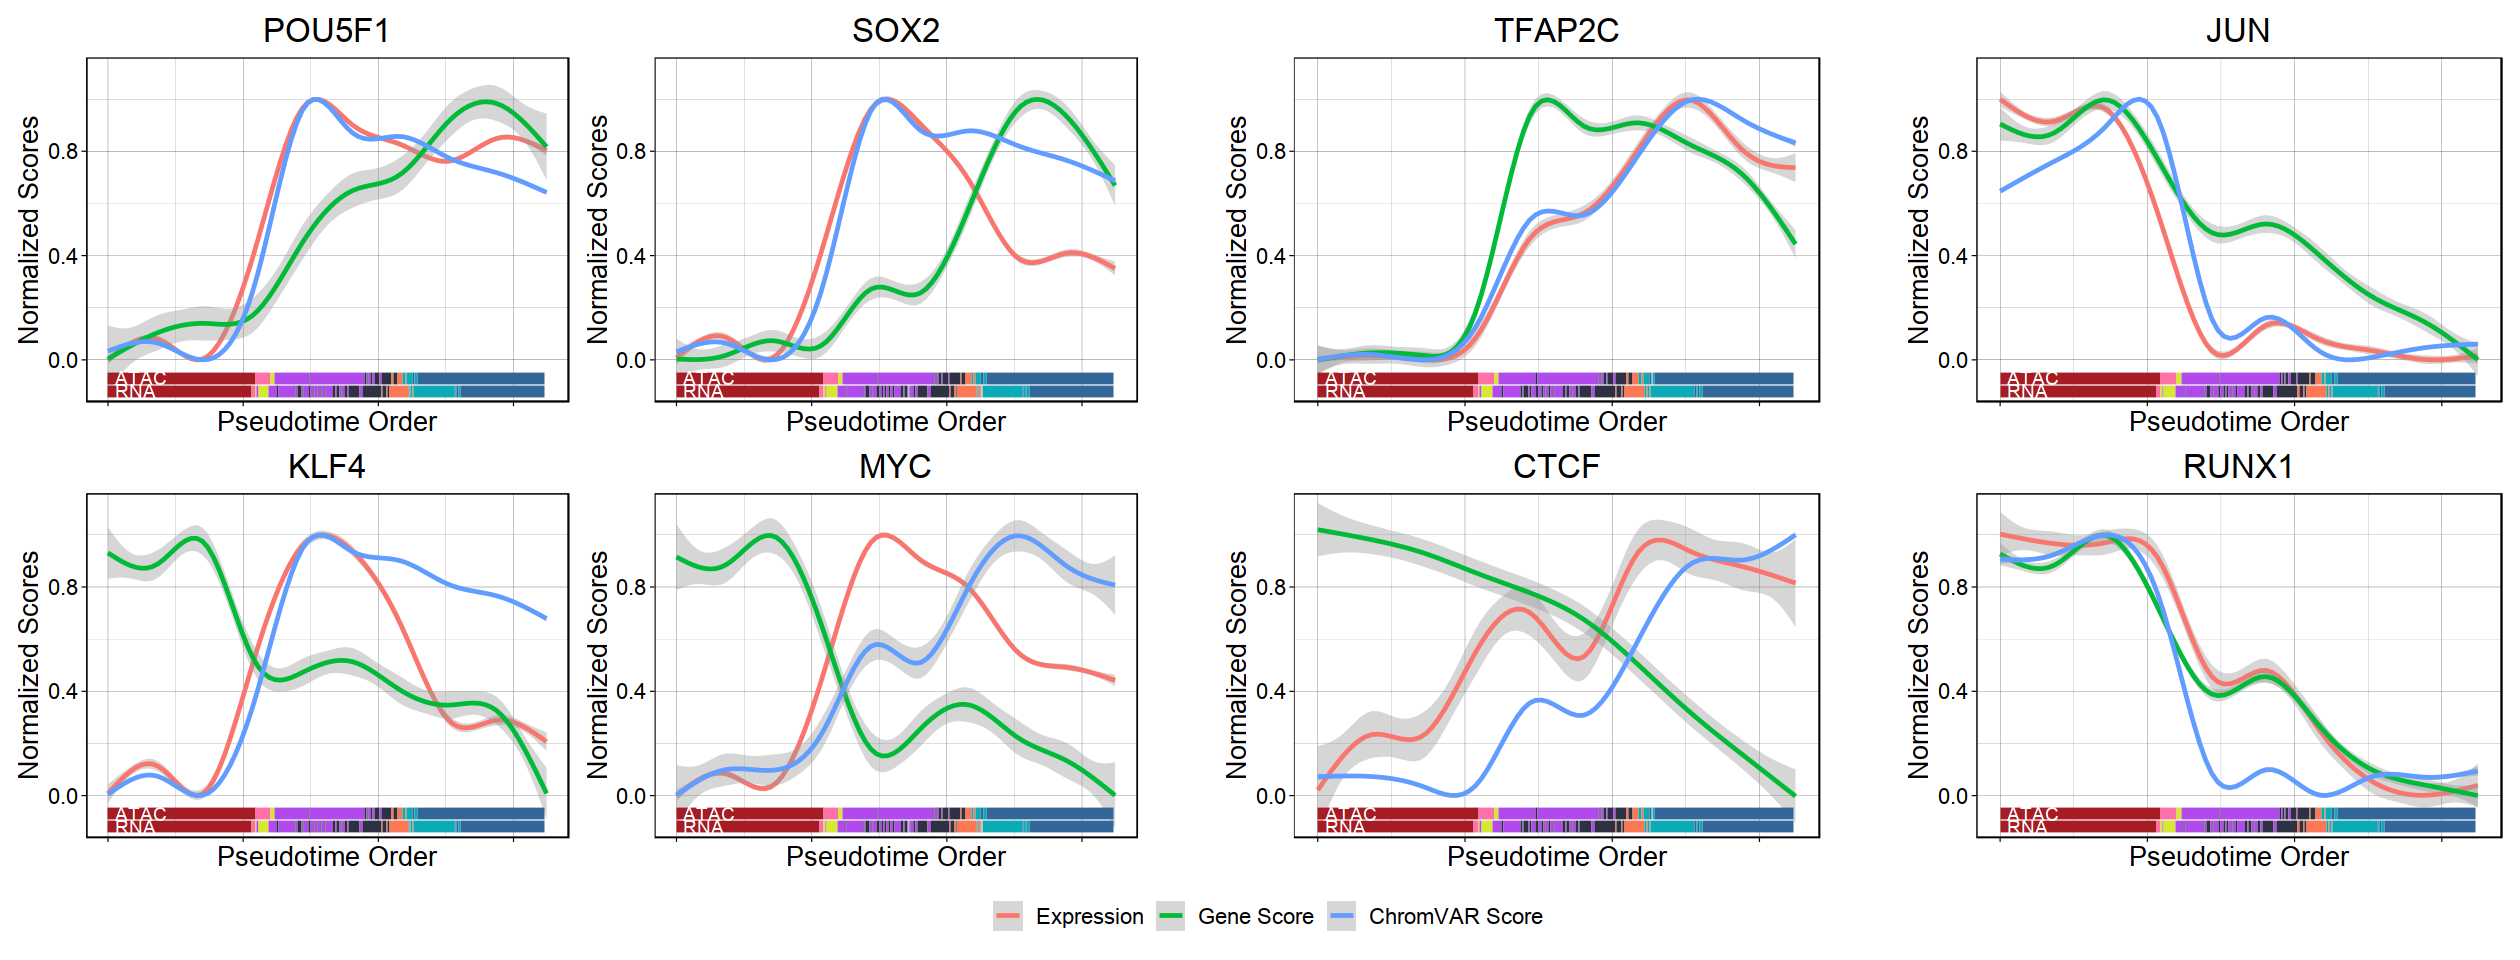

In [170]:
options(repr.plot.width = 21, repr.plot.height = 8)

combined_with_legend

In [251]:
saveRDS(combined_with_legend, file=sprintf("./subfigs/%s_genes.rds",
                                format(Sys.Date(), "%Y%m%d")))

---

In [ ]:
sessionInfo()